In [76]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

data = pd.read_csv('XSS_dataset.csv')
data2 = pd.read_csv('data1/augmented_xss_train_set.csv')
data3 = pd.read_csv('data1/augmented_xss_test_set.csv')

In [77]:
merged_data = pd.concat([data, data2, data3])
merged_data = merged_data.drop(columns=['Unnamed: 0'])
merged_data['Label'] = merged_data['Label'].map({0:0, 1:1, 'benign': 0, 'malicious': 1})
data = merged_data

In [78]:
vectorizer = CountVectorizer() # bag of words model

x_train, x_test, y_train, y_test = train_test_split(data['Payload'], data['Label'], test_size=0.2)

x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)

In [79]:
vectorizer.get_feature_names_out()

array(['00', '000', '0000', ..., 'ｅｘｐｒｅｓｓ', 'ｅｘｐｒｅｓｓｉｏｎ', 'ｏｎ'],
      dtype=object)

In [80]:
def train_evaluate_model(model, x_train, y_train, x_test, y_test, model_name, pos_label):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=pos_label)
    recall = recall_score(y_test, y_pred, pos_label=pos_label)
    f1 = f1_score(y_test, y_pred, pos_label=pos_label)
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

In [81]:
models = [
    (DecisionTreeClassifier(random_state=42), 'Decision Tree'),
    (SVC(kernel='linear', random_state=42), 'Support Vector Machine'),
    (LogisticRegression(random_state=42, max_iter=200), 'Logistic Regression'),
    (GaussianNB(), 'Naive Bayes'),
    (RandomForestClassifier(random_state=42), 'Random Forest')
]

In [82]:
results = []
for model, name in models:
    if name == "Naive Bayes":  # GaussianNB requires dense input
        results.append(train_evaluate_model(model, x_train.toarray(), y_train, x_test.toarray(), y_test, name, 1))
    else:
        results.append(train_evaluate_model(model, x_train, y_train, x_test, y_test, name, 1))

In [83]:
results_df = pd.DataFrame(results)
print(results_df)

                    Model  Accuracy  Precision    Recall  F1 Score
0           Decision Tree  0.996097   0.997169  0.996162  0.996665
1  Support Vector Machine  0.997635   0.998786  0.997172  0.997978
2     Logistic Regression  0.995388   0.998579  0.993535  0.996051
3             Naive Bayes  0.878666   0.828643  0.999394  0.906044
4           Random Forest  0.997871   0.998988  0.997374  0.998180


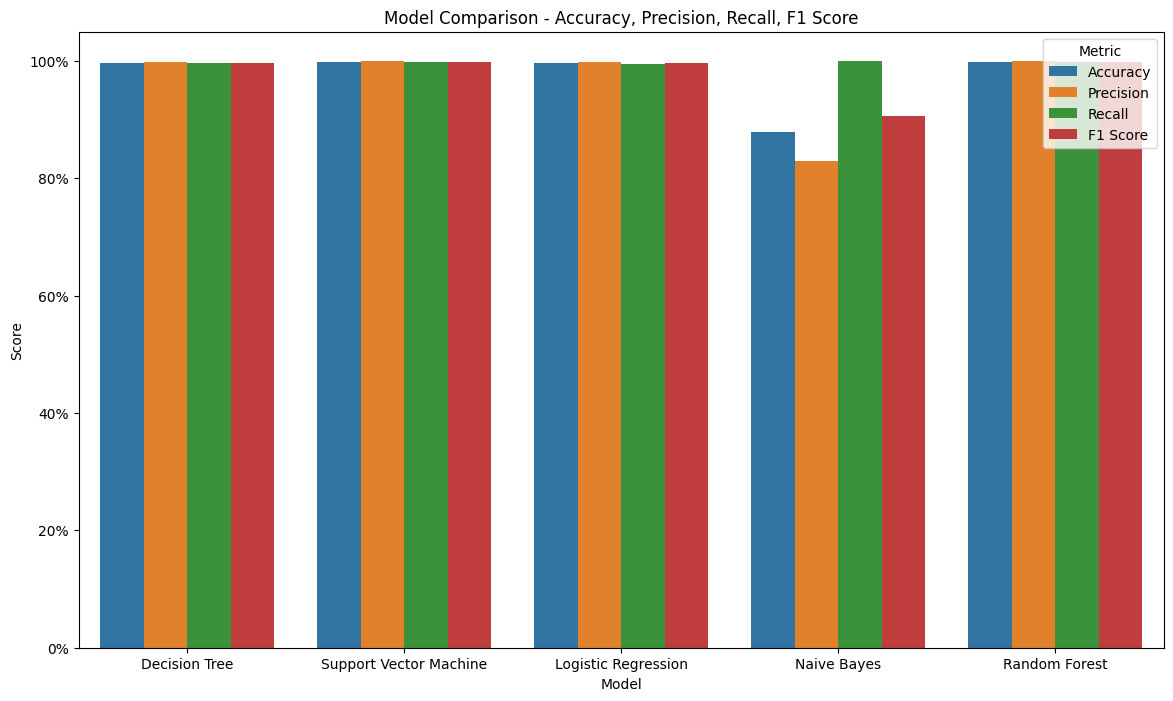

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

# Melt the results_df to long format for easier plotting with seaborn
results_long = results_df.melt(id_vars='Model', value_vars=['Accuracy', 'Precision', 'Recall', 'F1 Score'], 
                               var_name='Metric', value_name='Score')

plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='Score', hue='Metric', data=results_long)
plt.title('Model Comparison - Accuracy, Precision, Recall, F1 Score')
plt.ylabel('Score')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
plt.show()